****Part I**** - Use this
[dataset](https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip) to
train a CNN. Use no other data source or pretrained networks, and
explain your design choices during preprocessing, model building and
training. Also, cite the sources you used to borrow techniques. A test
set will be provided later to judge the performance of your classifier.
Please save your model checkpoints.

****Dataset Overview****

The dataset consists of 62 classes, with 40 samples of each sample.
Classes - \[0-9, A-Z, a-z\] Total number of images - 62\*40 = 2480
images

In [ ]:
# Image details
import torch
from skimage import io

img = io.imread("train/Sample001/img001-001.png")
io.imshow(img)
print(torch.tensor(img).shape)


****Establishing baselines****

In solving this task, my first approach was to establish a baseline
using a barebones CNN with minimal features. The outcome of this subtask
would be to assess performance on the dataset and provide a baseline for
future measurements. Pytorch and the Pytorch-lightning framework are
used in developing the neural network for this task. Pytorch Lightning
provides a high level API in developing the networks, while organizing
the code and making it easier to modify.

In [ ]:
import os
from typing import Optional

import torch
from skimage import io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


****Data Loading****

For handling all tasks relating to data and its loading, Pytorch
Lightning provides `LightningDataModule` [1], which wraps Pytorch's
`Dataset` and `DataLoader` abstractions, and provides a single interface
to access data.

The image paths and the classes to which they belong to are loaded from
the provided base directory. Initially, the images themselves were
loaded into memory instead of their filepaths, but my system was unable
to load the entrie dataset due to lack of memory. Thus the paths are
loaded, and during training, the images will be loaded using these
paths.

Cross-entropy is widely used as a loss function when optimizing
classification models [2], allowing us to quantify the difference
between the target probability distribution and the distribution of the
model's output.

In PyTorch, CrossEntropyLoss [3] expects *a list of class indices \[0,
C-1\]*, which means the target vector of classnames must be encoded into
a vector of integers. sklearn's `LabelEncoder()` transforms the target
vector into the appropriate encoding.

Finally, `train_test_split` is used to split the dataset into training,
validation and testing sets according to an 80-10-10 split.

[1] [LightningDataModule](https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html)

[2] [A Gentle Introduction to Cross-Entropy for Machine
Learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)

[3] [PyTorch
CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [ ]:
class NumbersAndLettersDataset(Dataset):
    ''' Dataset for numbers and letters. '''
    def __init__(self, input_data, target, transform=None):
        self.input_data = input_data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        img = torch.tensor(io.imread(self.input_data[idx]))
        img = img.permute(2, 0, 1) # Reshape to bring channels to first index
        return (img, self.target[idx])

class NumbersAndLettersModule(pl.LightningDataModule):
    ''' DataModule for loading of dataset. '''
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.nal_train = None
        self.nal_test = None
        self.nal_val = None

    def setup(self, stage: Optional[str] = None):
        if stage in (None, 'fit'): # Create all datasets
            img_dataset, img_classes = self.load_data(self.data_dir)
            print("Data loaded from disk")

            # Prepare target using Label Encoding
            le = LabelEncoder()
            le.fit(img_classes)
            img_classes = torch.tensor(le.transform(img_classes))

            dataset = NumbersAndLettersDataset(img_dataset, img_classes)

            # Creating train, test, val datasets according to an 80-10-10 split
            self.nal_train, self.nal_test = train_test_split(dataset, test_size=0.1)
            self.nal_train, self.nal_val = train_test_split(self.nal_train, test_size=0.1)

    def train_dataloader(self):
        return DataLoader(self.nal_train, batch_size=self.batch_size, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.nal_val, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.nal_test, batch_size=self.batch_size, num_workers=4)

    def load_data(self, img_dir):
        ''' Load image_paths and their classes from disk. '''
        dataset = []
        classes = []
        for folder in os.listdir(img_dir):
            img_class = int(folder[-2:]) # Extract last 2 digits of folder name
            if img_class < 11:
                img_class = str(img_class - 1) # 0-9
            elif img_class < 37:
                img_class = chr(img_class + 54) # A-Z
            else: img_class = chr(img_class + 60) # a-z
            for img in os.listdir(os.path.join(img_dir, folder)):
                img_path = os.path.join(img_dir, folder, img)
                dataset.append(img_path)
                classes.append(img_class)
        return dataset, classes

SEED = 42 # Set a global seed for reproducible results
BATCH_SIZE = 4
BASE_DIR = "train"

INPUT_DIM = torch.tensor([3, 900, 1200])

pl.utilities.seed.seed_everything(SEED)

# Create DataModule to handle loading of dataset
data_module = NumbersAndLettersModule(BASE_DIR, BATCH_SIZE)


In building the CNN, I decided to implement a simple CNN to understand
what the baseline performance looks like. Thus, the design decision in
building this CNN were guided by using standard domain knowledge without
additional features.

**Network Architecture**

In designing the network, I referred to CS231, Stanford's course on CNNs
[1], in which they present a stacked CONV-RELU followed by POOL layers
as the most common architecture. I have opted for a similar design of 4
repeating CONV-POOL-RELU stacks. After this, the output of the 4th stack
is flattened into a 1D vector and then fed to three fully connected
layers, gradually bringing down the dimensionality of the vector to that
of the number of output classes.

In PytorchLightning, the `LightningModule` is used to build neural nets,
and it exposes various methods to simplify the process.

1.  `forward` -\> The forward pass.
2.  `configure_optimizers` -\> Return the optimizer to be used in
    training
3.  `{training, validation, test}_step` -\> These functions expose the
    training, validation and test loops respectively. In these
    functions, the input is propagated through the network, following
    which the cross entropy loss is computed.

*Loss* -\> As common in classification tasks, Cross Entropy Loss is
used. *Optimizer* -\> Again, the standard choice is the Adam optimizer
and it has been selected.

**Logging**

I consider logging very important, especially while experimenting with
different architectures, it is important to have a baseline stored so
future changes can be compared against it. For logging, I have used the
Weights and Biases logger integrated into Pytorch Lightning. It allows
for live tracking on their website and export of results.

[1] [CS231N](https://cs231n.github.io/convolutional-networks/)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NumbersAndLettersCNN(pl.LightningModule):
    ''' Implementation of CNN to detect numbers and letters. '''
    def __init__(self, input_dim, output_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(input_dim[0], 16, 6)
        self.conv2 = nn.Conv2d(16, 64, 6)
        self.conv3 = nn.Conv2d(64, 128, 6)
        self.conv4 = nn.Conv2d(128, 256, 6)
        self.pool = nn.MaxPool2d(3)
        self.fc1 = nn.Linear(256 * 8 * 12, 4096)
        self.fc2 = nn.Linear(4096, 256)
        self.fc3 = nn.Linear(256, output_classes)

    def forward(self, x):
        ''' Forward pass '''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x.float())
        loss = F.cross_entropy(output, y.long())
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x.float())
        loss = F.cross_entropy(output, y.long())
        acc = torch.mean((torch.argmax(output, axis=1) == y).float())
        self.log_dict({'val_loss': loss, 'val_acc': acc})

    def test_step(self, batch, batch_idx):
        x, y = batch
        output = self(x.float())
        loss = F.cross_entropy(output, y.long())
        acc = torch.mean((torch.argmax(output, axis=1) == y).float())
        self.log_dict({'test_loss': loss, 'test_acc': acc})

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

MODEL_NAME = 'numbers-and-letters-cnn'

INPUT_DIM = torch.tensor([3, 900, 1200])
OUTPUT_CLASSES = 62

# Train and test model

model = NumbersAndLettersCNN(INPUT_DIM, OUTPUT_CLASSES)

# Log metrics to WandB
wandb_logger = pl.loggers.WandbLogger(save_dir='logs/',
                                        name="%s.pth" %MODEL_NAME,
                                        project='midas-task-2')
trainer = pl.Trainer(gpus=1, logger=wandb_logger, max_epochs=1)
trainer.fit(model, data_module)
trainer.test(model=model, datamodule=data_module)


When I started training the model, I quickly ran into Out-of-Memory
exceptions. I am training on a laptop with 4GB VRAM, and the network I
had initially designed was too large for my machine. My first approach
was to reduce the batch size from 64 progressively until 4.

Even this was not sufficient for the network to run on my GPU and my
next approach was to more aggressively use the Convolution and Pooling
layers. The Pooling Layer's kernel size was increased to (3,3) from
(2,2) to reduce the input vector size faster and similarly the size of
the kernel of the Conv2D layers was also increased from (5,5) to (6,6),
convolving over a larger window each time.

With these enhancements, I was able to run the network on my machine,
complete a training loop on one epoch, fix the bugs and complete the
training pipeline.

Since the model was very large (\~400MB) and required a lot of time to
train even one epoch, I decided to modify the architecture referring to
CS231N [1] and a StackOverflow question [2] asking about the handling of
large images in CNNs. Since the input images were \[3, 1200, 900\], a
large image, especially for simple classification of letters/numbers,
the following changes were implemented:

1.  Reduce the number of FC layers to have a more manageable network -\>
    Since FC layers take most of the parameters (and hence contribute
    the most to model size) because they are densely connected, only one
    FC layer is now used.
2.  Downsample the image before passing it into the network -\> The
    image is MaxPooled once *before* being passed into the network, so
    that the network doesn't need to handle sucha a large image.
3.  Since the classification is fairly simple, increase the stride of
    the Conv layers -\> For further "downsampling", increase the stride
    to (2,2) from (1,1) so as to reduce the vector to a manageable size.
4.  Apply pooling on alternate convolutions -\> Since pooling is a
    destructive operation, it is applied after every two convolutions
    rather than after each. This also compensates for the previous two
    points which reduce the size of the input tensor.

An EarlyStopping callback was also added, monitoring the validation loss
and stopping training if the metric ceased to decrease for 3 consecutive
epochs.

With the above changes, NumbersAndLettersCNN v2 was tested.

[1] [CS231N](https://cs231n.github.io/convolutional-networks/)

[2] [How do I handle large images when training a
CNN?](https://ai.stackexchange.com/questions/3938/how-do-i-handle-large-images-when-training-a-cnn)

In [ ]:

# NumbersAndLettersCNN V2

class NumbersAndLettersCNN(pl.LightningModule):
    ''' Implementation of CNN to detect numbers and letters. '''
    def __init__(self, input_dim, output_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(input_dim[0], 64, 3, padding=2, stride=2)
        self.conv2 = nn.Conv2d(64, 256, 3, padding=2, stride=2)
        self.pool = nn.MaxPool2d(4)
        self.fc1 = nn.Linear(256 * 14 * 19, output_classes)

    def forward(self, x):
        ''' Forward pass '''
        x = self.pool(x) # Downsample image
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x.float())
        loss = F.cross_entropy(output, y.long())
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x.float())
        loss = F.cross_entropy(output, y.long())
        acc = torch.mean((torch.argmax(output, axis=1) == y).float())
        self.log_dict({'val_loss': loss, 'val_acc': acc}, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        output = self(x.float())
        loss = F.cross_entropy(output, y.long())
        acc = torch.mean((torch.argmax(output, axis=1) == y).float())
        self.log_dict({'test_loss': loss, 'test_acc': acc}, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
)

trainer = pl.Trainer(gpus=1, logger=wandb_logger,
                     callbacks=[early_stopping], min_epochs=5)
trainer.fit(model, data_module)
trainer.test(model=model, datamodule=data_module)



The result was quite unexpected. While the training loss kept going
down, the validation loss started increasing after the very first epoch
itself, indicating *overfitting*. After checking for other errors in the
implementation, I concluded that it was indeed overfitting and that a
much smaller and simpler model would be sufficient. The information that
MNIST (28x28) and CIFAR-10 (32x32) could be classified to high
accuracies using such small input images led me to work on input
preprocessing as the next step.

As part of input preprocessing, I took the following steps:

1.  Resize input image - Since popular datasets like CIFAR and MNIST can
    be learnt very well using only \~30x30 images, I downsampled the
    images drastically from 900x1200 to 30x40 \[a 30x decrease\].
2.  Grayscale images - To reduce the amount of data even further, I
    transformed the images into grayscale. Since the dataset only
    consists of black text on a white background, I considered it
    sufficient to have one channel rather than 3.
3.  Augmentation - Finally, I added a *Gaussian Blur* transformation, to
    augment the data and reduce the possibility of overfitting.

With these modifications, I trained the model again, and it started
overfitting after the first few epochs itself, not managing to climb
above 40% in validation accuracy. My next experiments were with
different architectures, including popular ones like LeNet [1], to no
avail, the model still overfit after a few epochs.

Finally, considering that there might be something wrong with the
implementation itself, I tested the model against traditional MNIST
data, against which it performed very well, reaching around 98%
accuracy. This verified the correctness of my implementation and
confirmed that the problem was with the data processing.

From training with MNIST, I realized three things:

1.  Colour inversion - MNIST data is white text (pixel colour 255) on
    black background (pixel colour 0). This meant that the majority of
    pixels were 0 and the pixels of interest had high values, whereas it
    was the opposite in the LettersAndNumbers dataset. Intuitively and
    according to [2], the weights corresponding to a 0 in the input will
    not be updated, causing poor learning. Thus, as part of the input
    pipeline, I included an **inversion** step to invert the colour of
    the input image.
2.  Normalization - Up to this point, I had not considered the input
    values going into the network and seeing MNIST tutorials normalizing
    input data, I realized that I was not performing normalization. I
    computed the mean and stddev of the dataset and then normalized the
    data with this information.
3.  Dataset size - MNIST only has 10 classes to classify into, and yet a
    dataset of 60000 images is used. In this case, nearly 30x less
    images are used to classify 6x more classes. This made me realize
    why the model was overfitting so quickly and I added more
    transformations to the pipeline. Namely RandomRotation to rotate the
    image randomly by (-30, 30) degrees and a Noise function, to add
    some Gaussian noise to the image. Finally, I added dropout with
    probability 0.8 on the input layer and 0.5 on the hidden layers, to
    force the network to be more robust. [3]

[1] [Review: LeNet-1, LeNet-4, LeNet-5, Boosted LeNet-4 (Image
Classification)](https://sh-tsang.medium.com/paper-brief-review-of-lenet-1-lenet-4-lenet-5-boosted-lenet-4-image-classification-1f5f809dbf17)

[2] [Impact of inverting grayscale values on mnist
dataset](https://stats.stackexchange.com/questions/220164/impact-of-inverting-grayscale-values-on-mnist-dataset?noredirect=1&lq=1)

[3] [A Gentle Introduction to Dropout for Regularizing Deep Neural
Networks](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)

In [ ]:

# The get item function from the NumbersAndLettersDataset
# Image is read as grayscale, inverted and transformed before being passed through the network
def __getitem__(self, idx):
    img = io.imread(self.input_data[idx], as_gray=True)
    img = torch.tensor(util.invert(img)) # Invert colours to be white on black
    img = torch.unsqueeze(img, 0)
    if self.transform: img = self.transform(img)
    return (img, self.target[idx])

# Transformation pipeline
# Images are resized, normalized and then augmented with [Blur, Rotation, Noise] as part of the pipeline
transform = transforms.Compose([
    transforms.Resize((30, 40)), # Scale down image
    transforms.Normalize((0.0583), (0.2322)),
    transforms.GaussianBlur(3),
    transforms.RandomRotation(30),
    transforms.Lambda(lambda img: img + np.random.normal(size=np.array(img.shape), scale=0.05)),
])


With these changes I trained the network again. While the model
overfitted again, the performance was better this time, with validation
accuracy going above 50%.

At this point, it seemed to be that the biggest thing holding the
accuracy back was the lack of data, so I focused on increasing both the
intensity and the number of data augmentation transforms. Images were
rotated more and a translation transform was also which translated the
image along the horizontal and vertical axes.

This change boosted the accuracy further by 10%. However, increasing
augmentations beyond this had a detrimental effect and reduced the
accuracy on the test set.

In order to verify whether data was indeed the limiting factor, I tested
the network on EMNIST [1], an extended verison of MNIST consisting of 62
classes as well. On EMNIST, the validation accuracy saturated at 80%
before overfitting.

-   The massively increased number of data (nearly 13000 samples per
    class) contributed significantly to the accuracy, validating my
    hypothesis.
-   However, the accuracy was **still** only 80%, indicating the limits
    of this network's architecture, suggesting that a deeper and bigger
    network might be able to learn better.

I decided to visualize the results of the confusion matrix, in order to
better understand where the network was going wrong. Below, I have also
visualized the graphs for loss and accuracy from WandB. The results of
two runs are visualized and the meaning behind the naming convetion is
as follows:

**5conv1fc<sub>drop10xblur</sub>&rotate&jitter&affine**

1.  *5conv1fc* - Signifies the network architecture i.e. 5 convolutional
    layers followed by one fully connected layer.
2.  *drop* - Indicates the use of dropout as a regularization mechanism.
3.  *10x* - Indicates the scale by which the image was resized. In this
    run, the image was resized from 900x1200 to 90x120 \[10x
    reduction\].
4.  *blur&rotate&jitter&affine* - Indicates the data augmentation
    transforms that have been used. The Gaussian Blur, Rotation, Jitter
    and Affine (vertical/horizontal translate) transforms have been
    used.

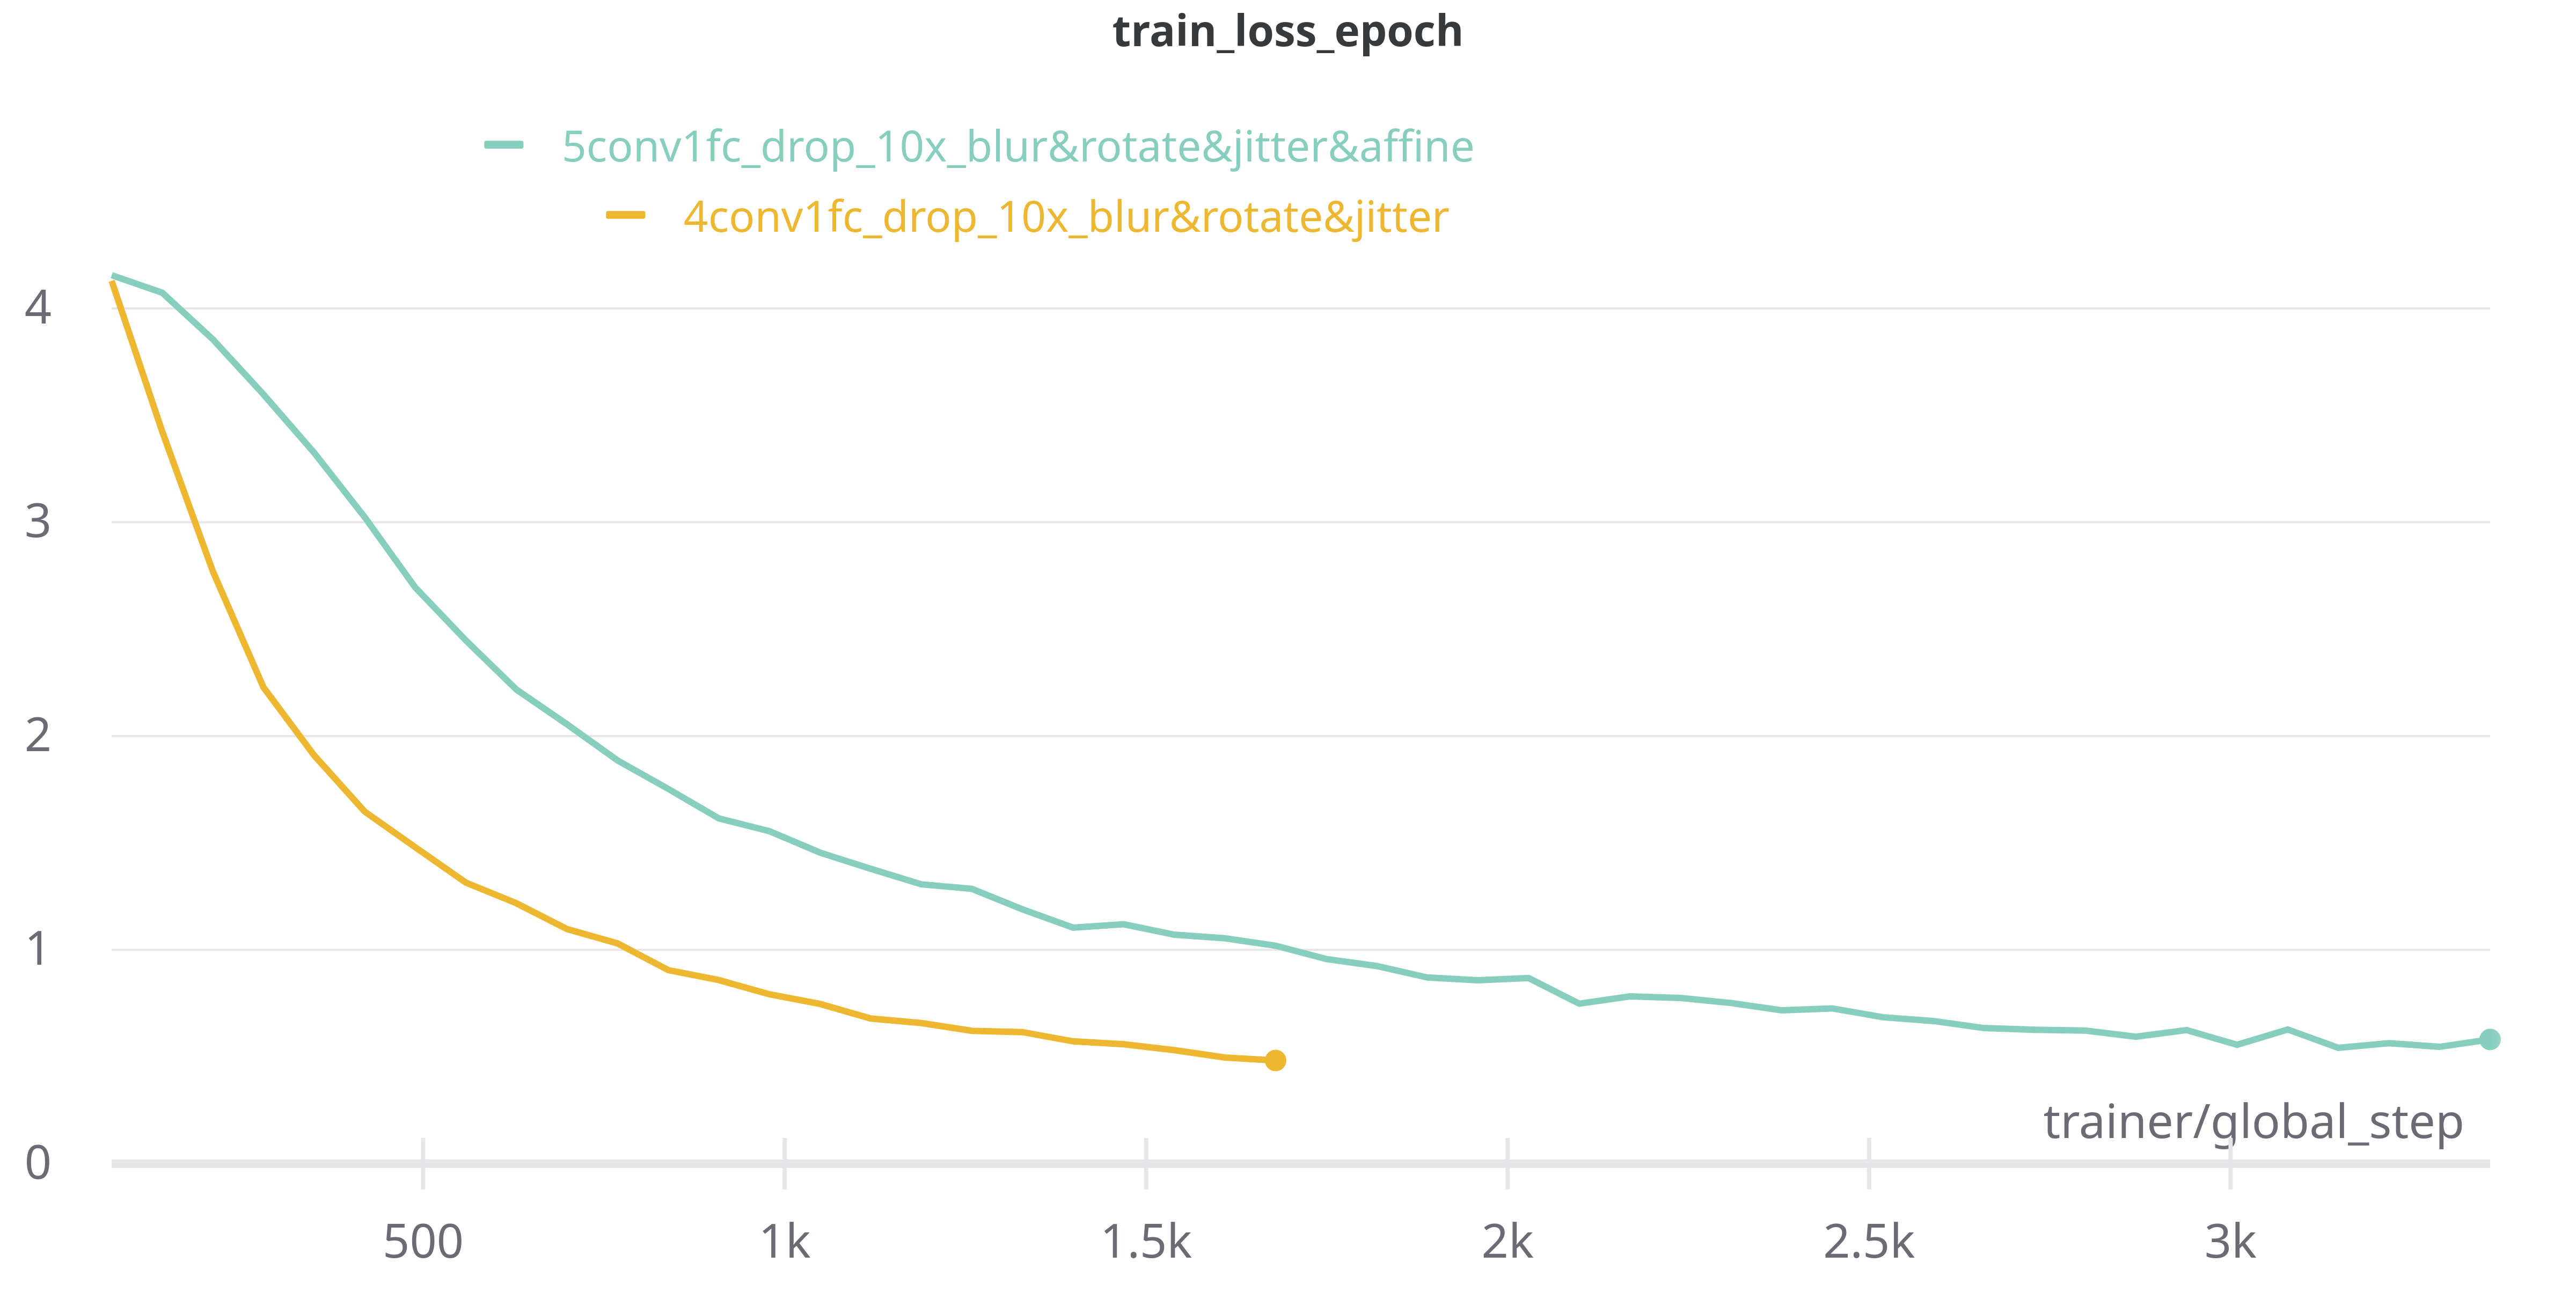

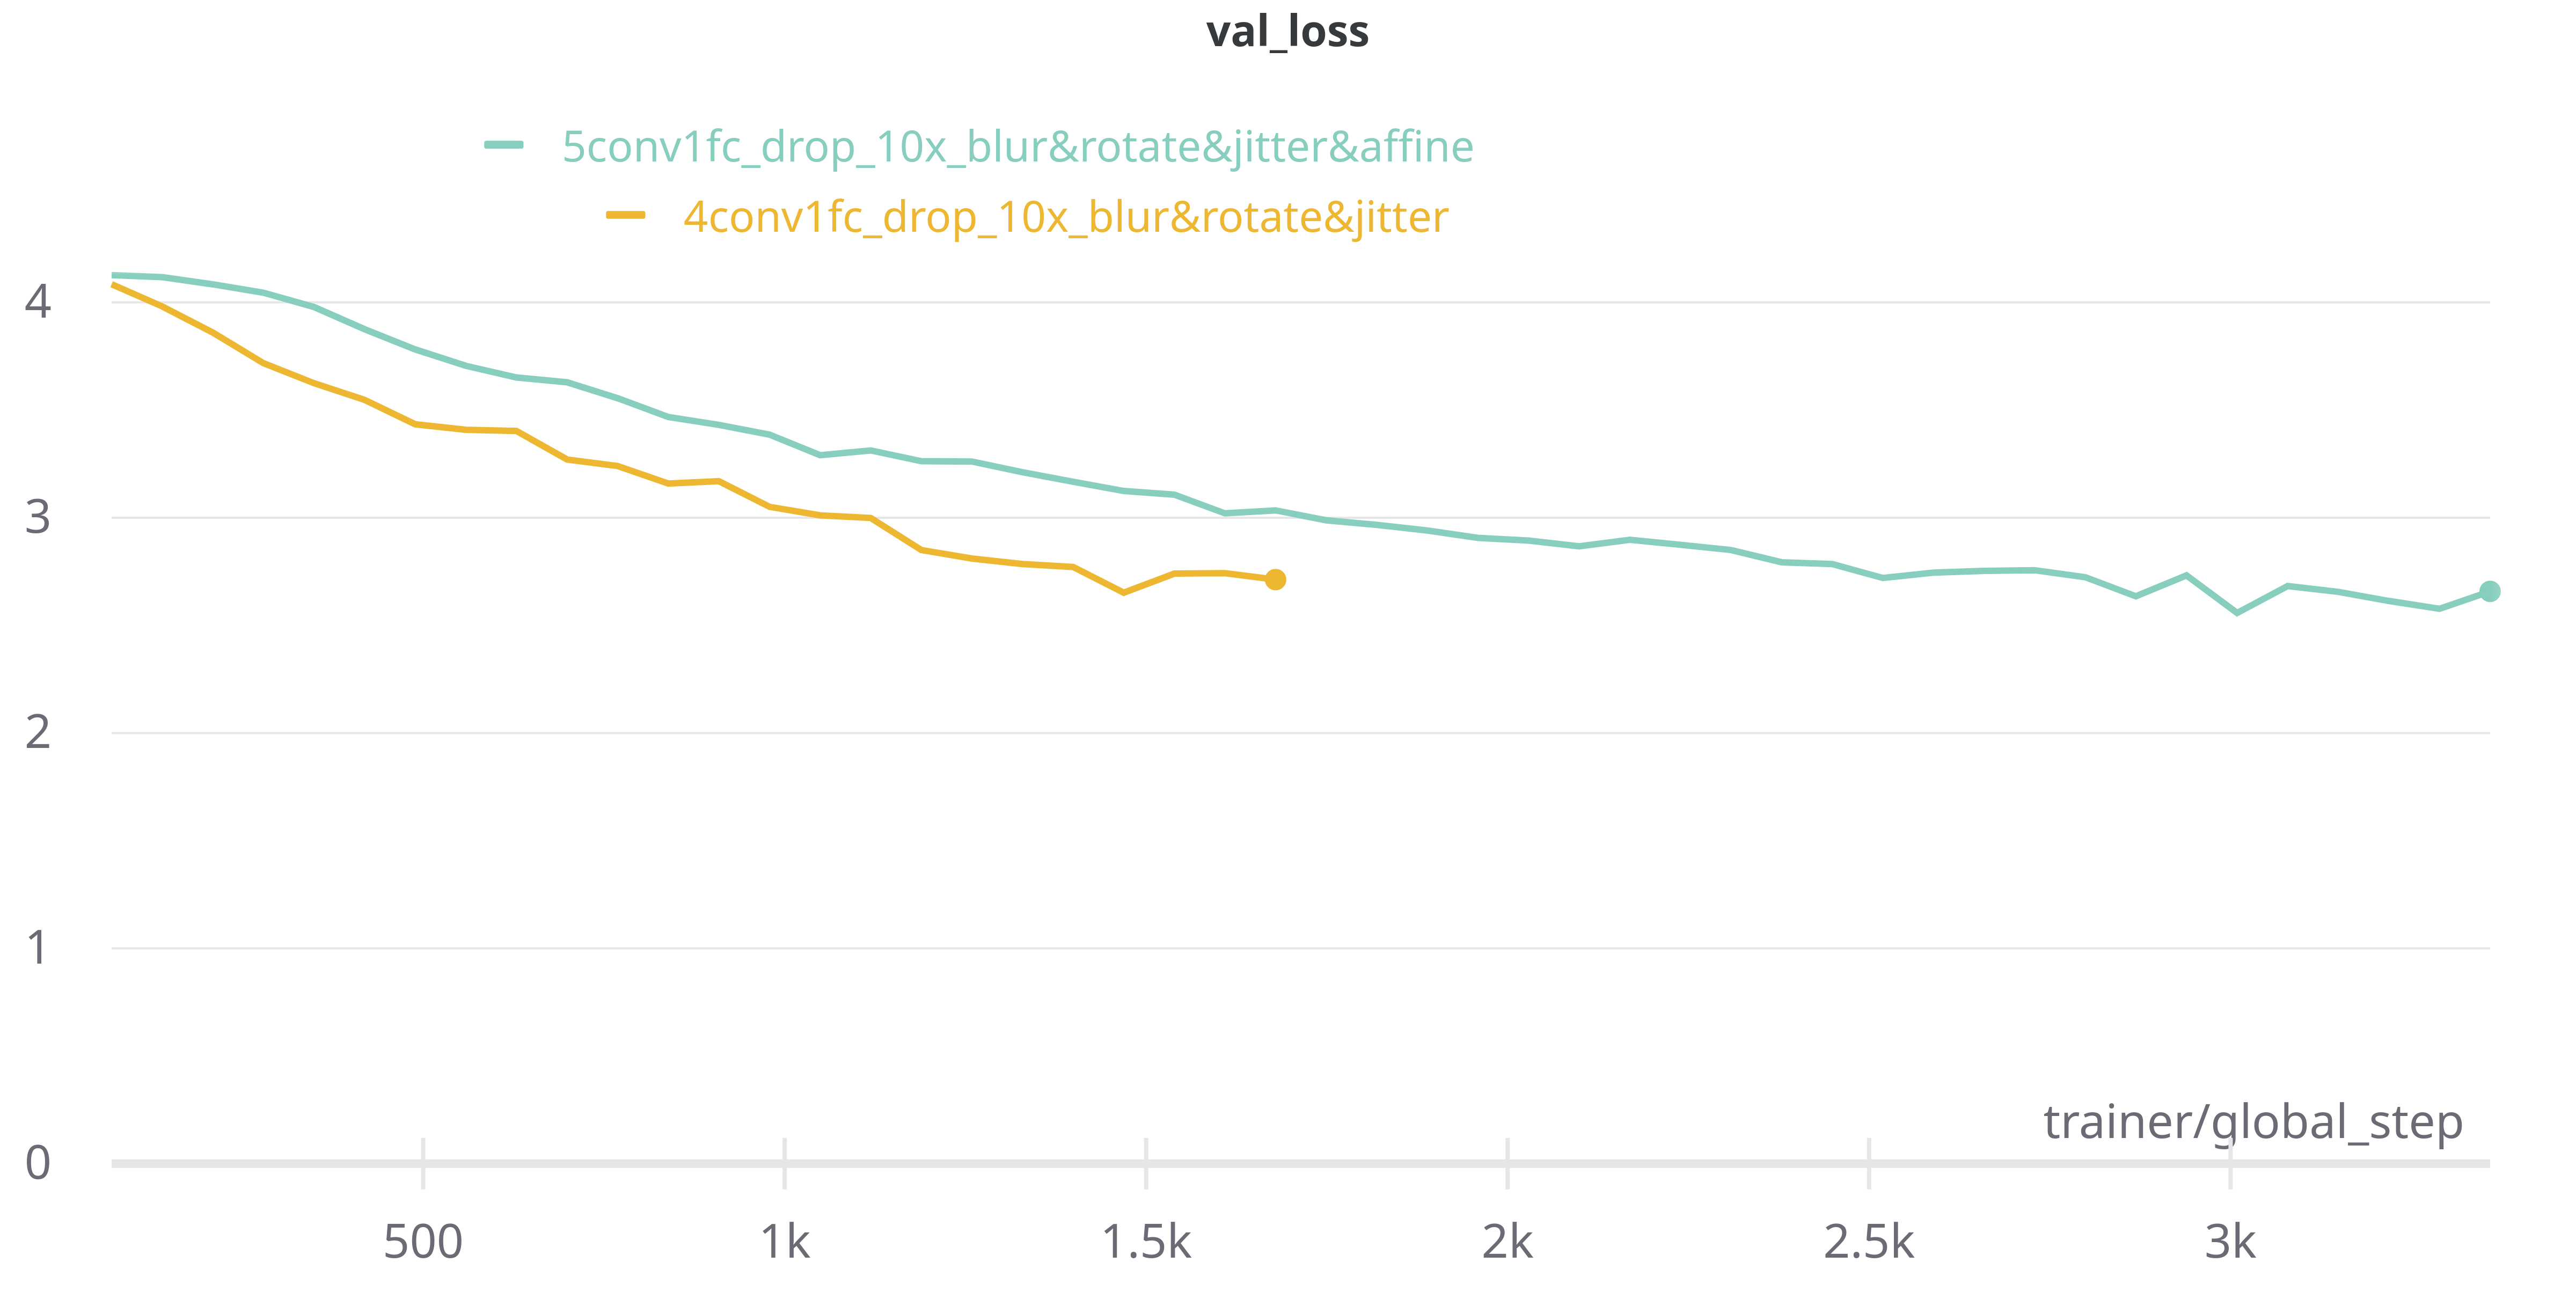

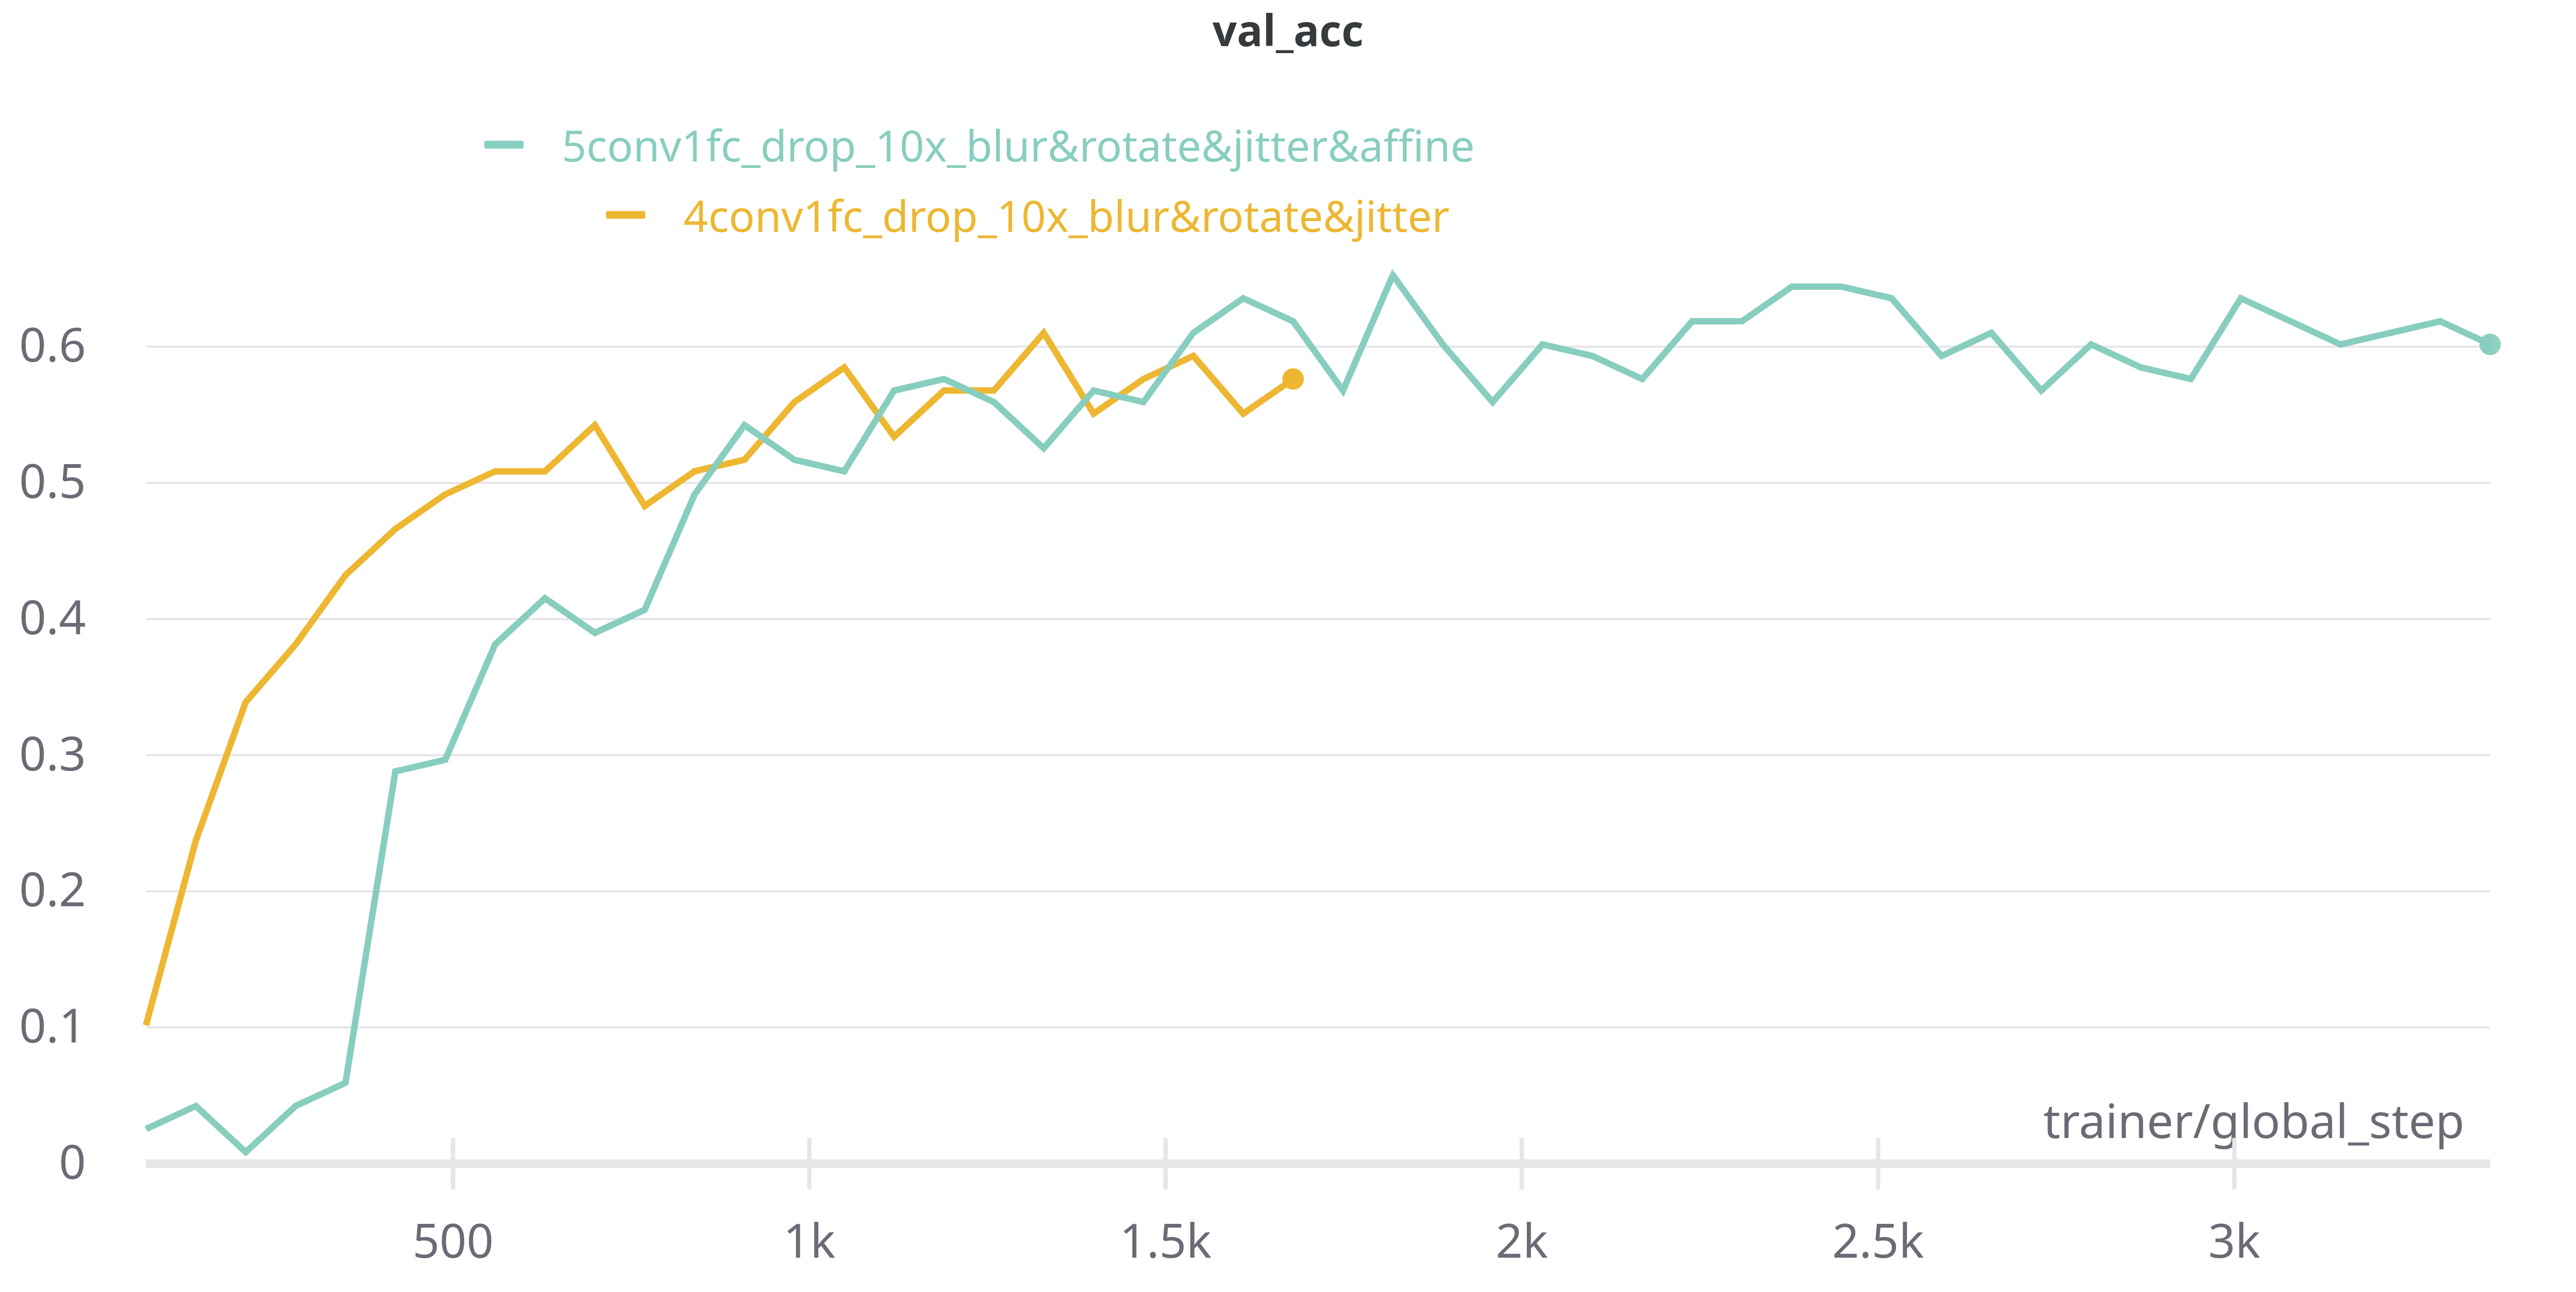

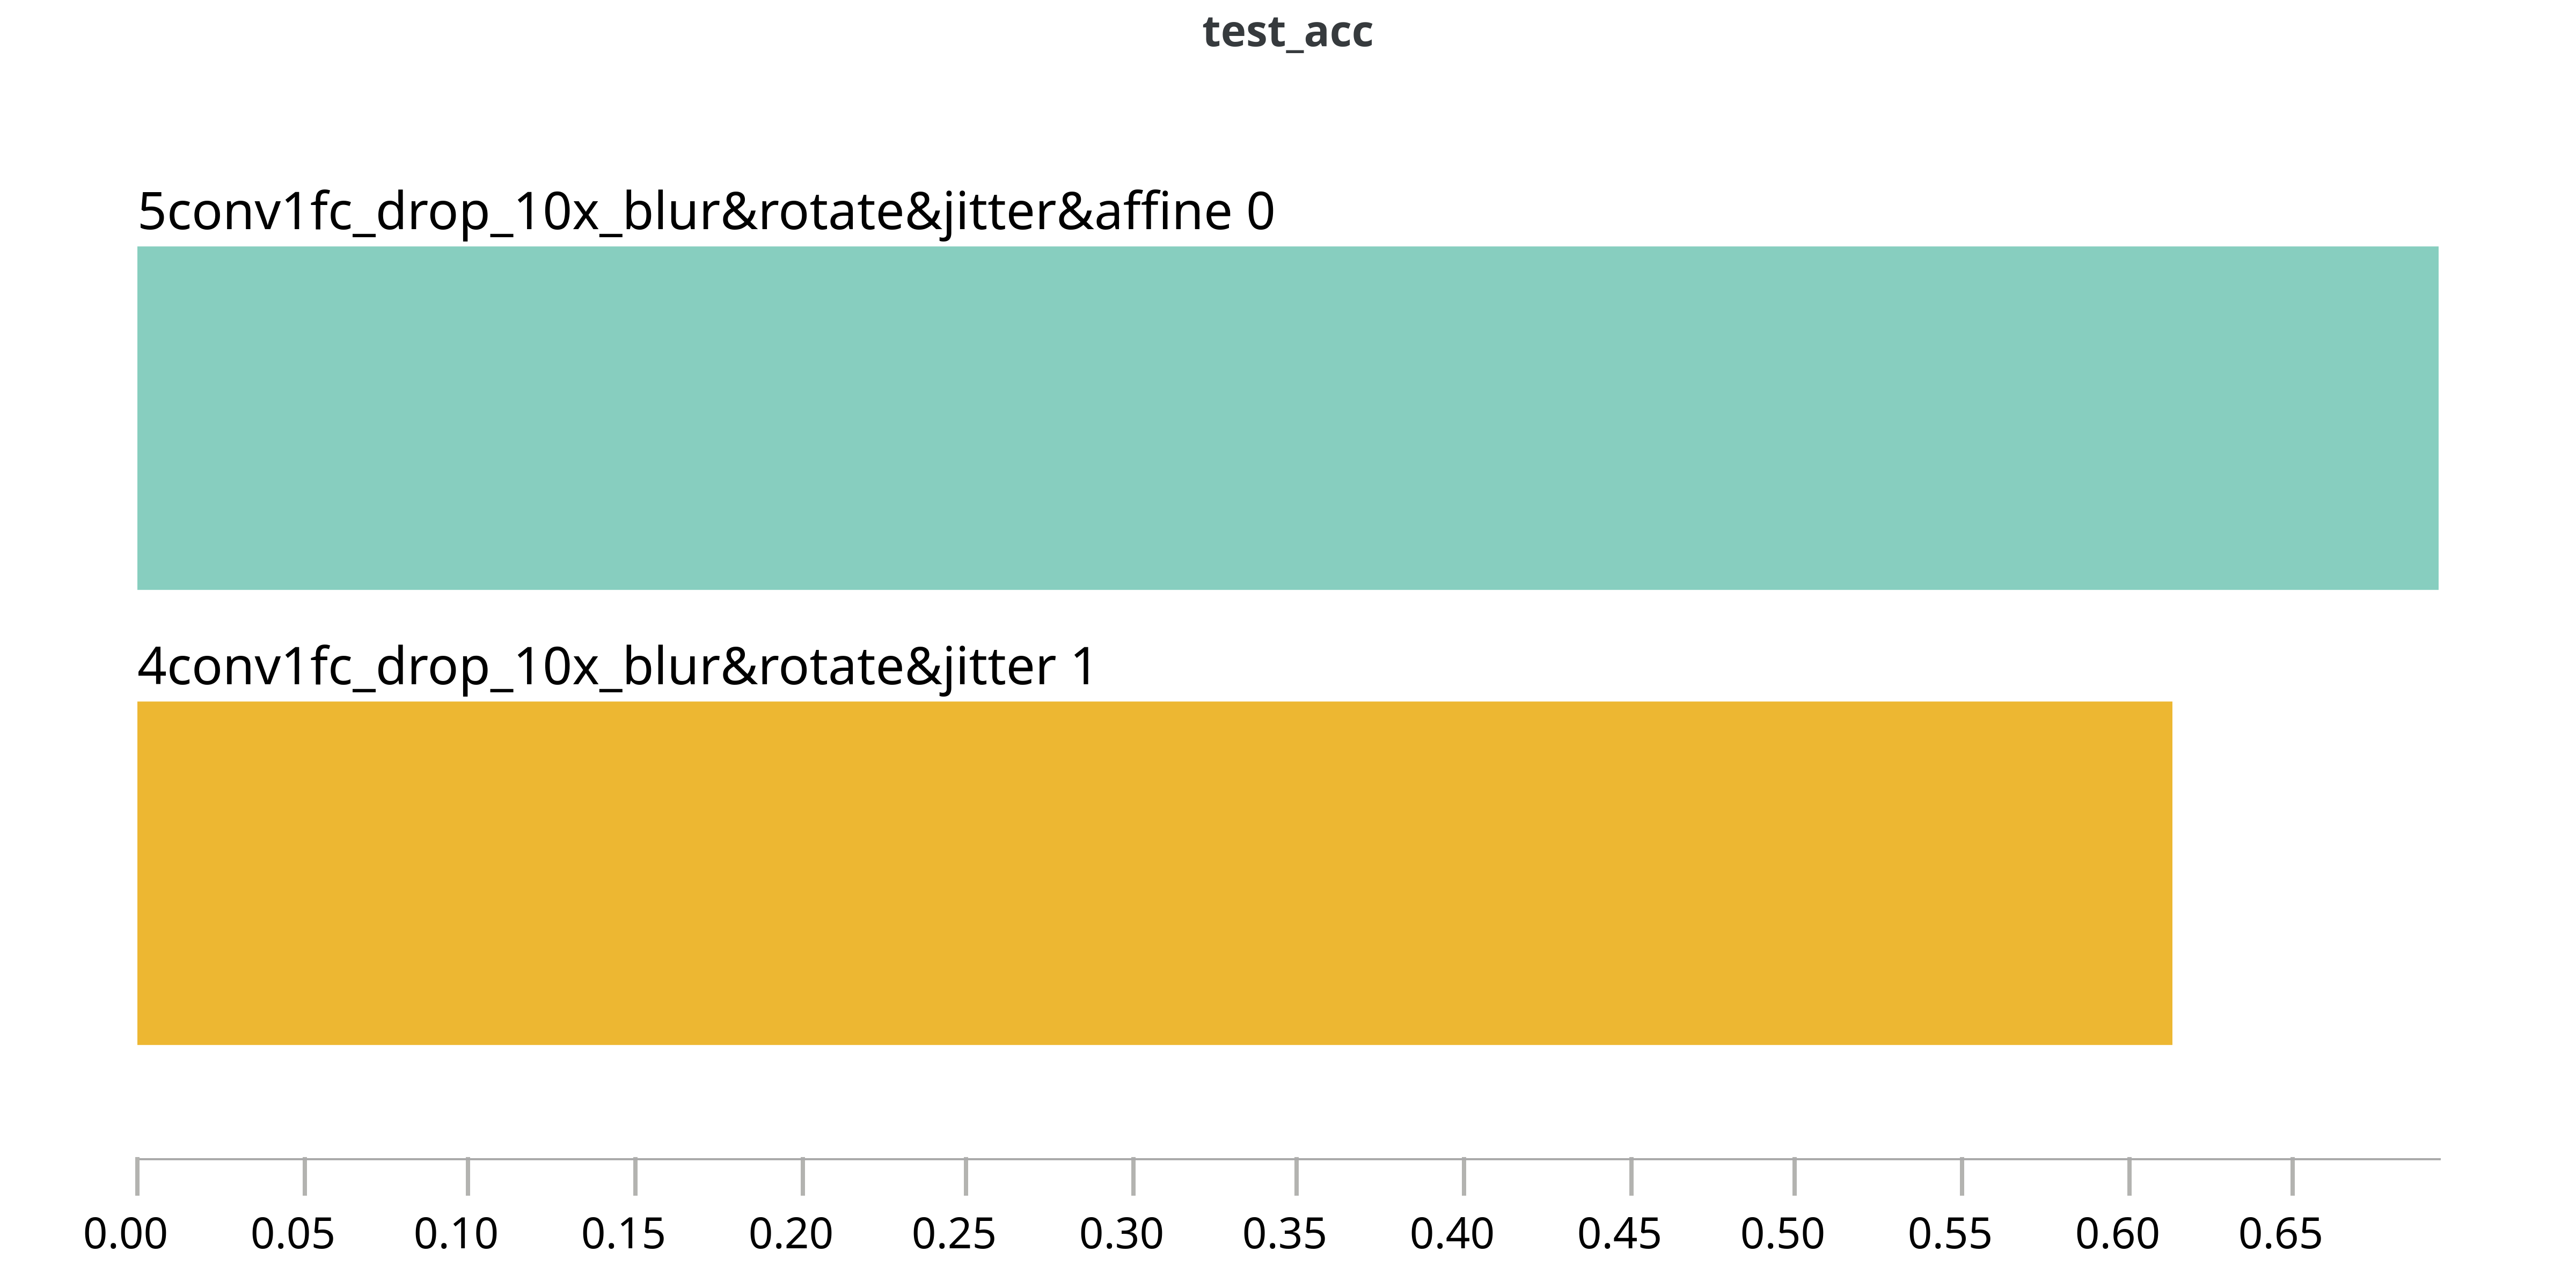

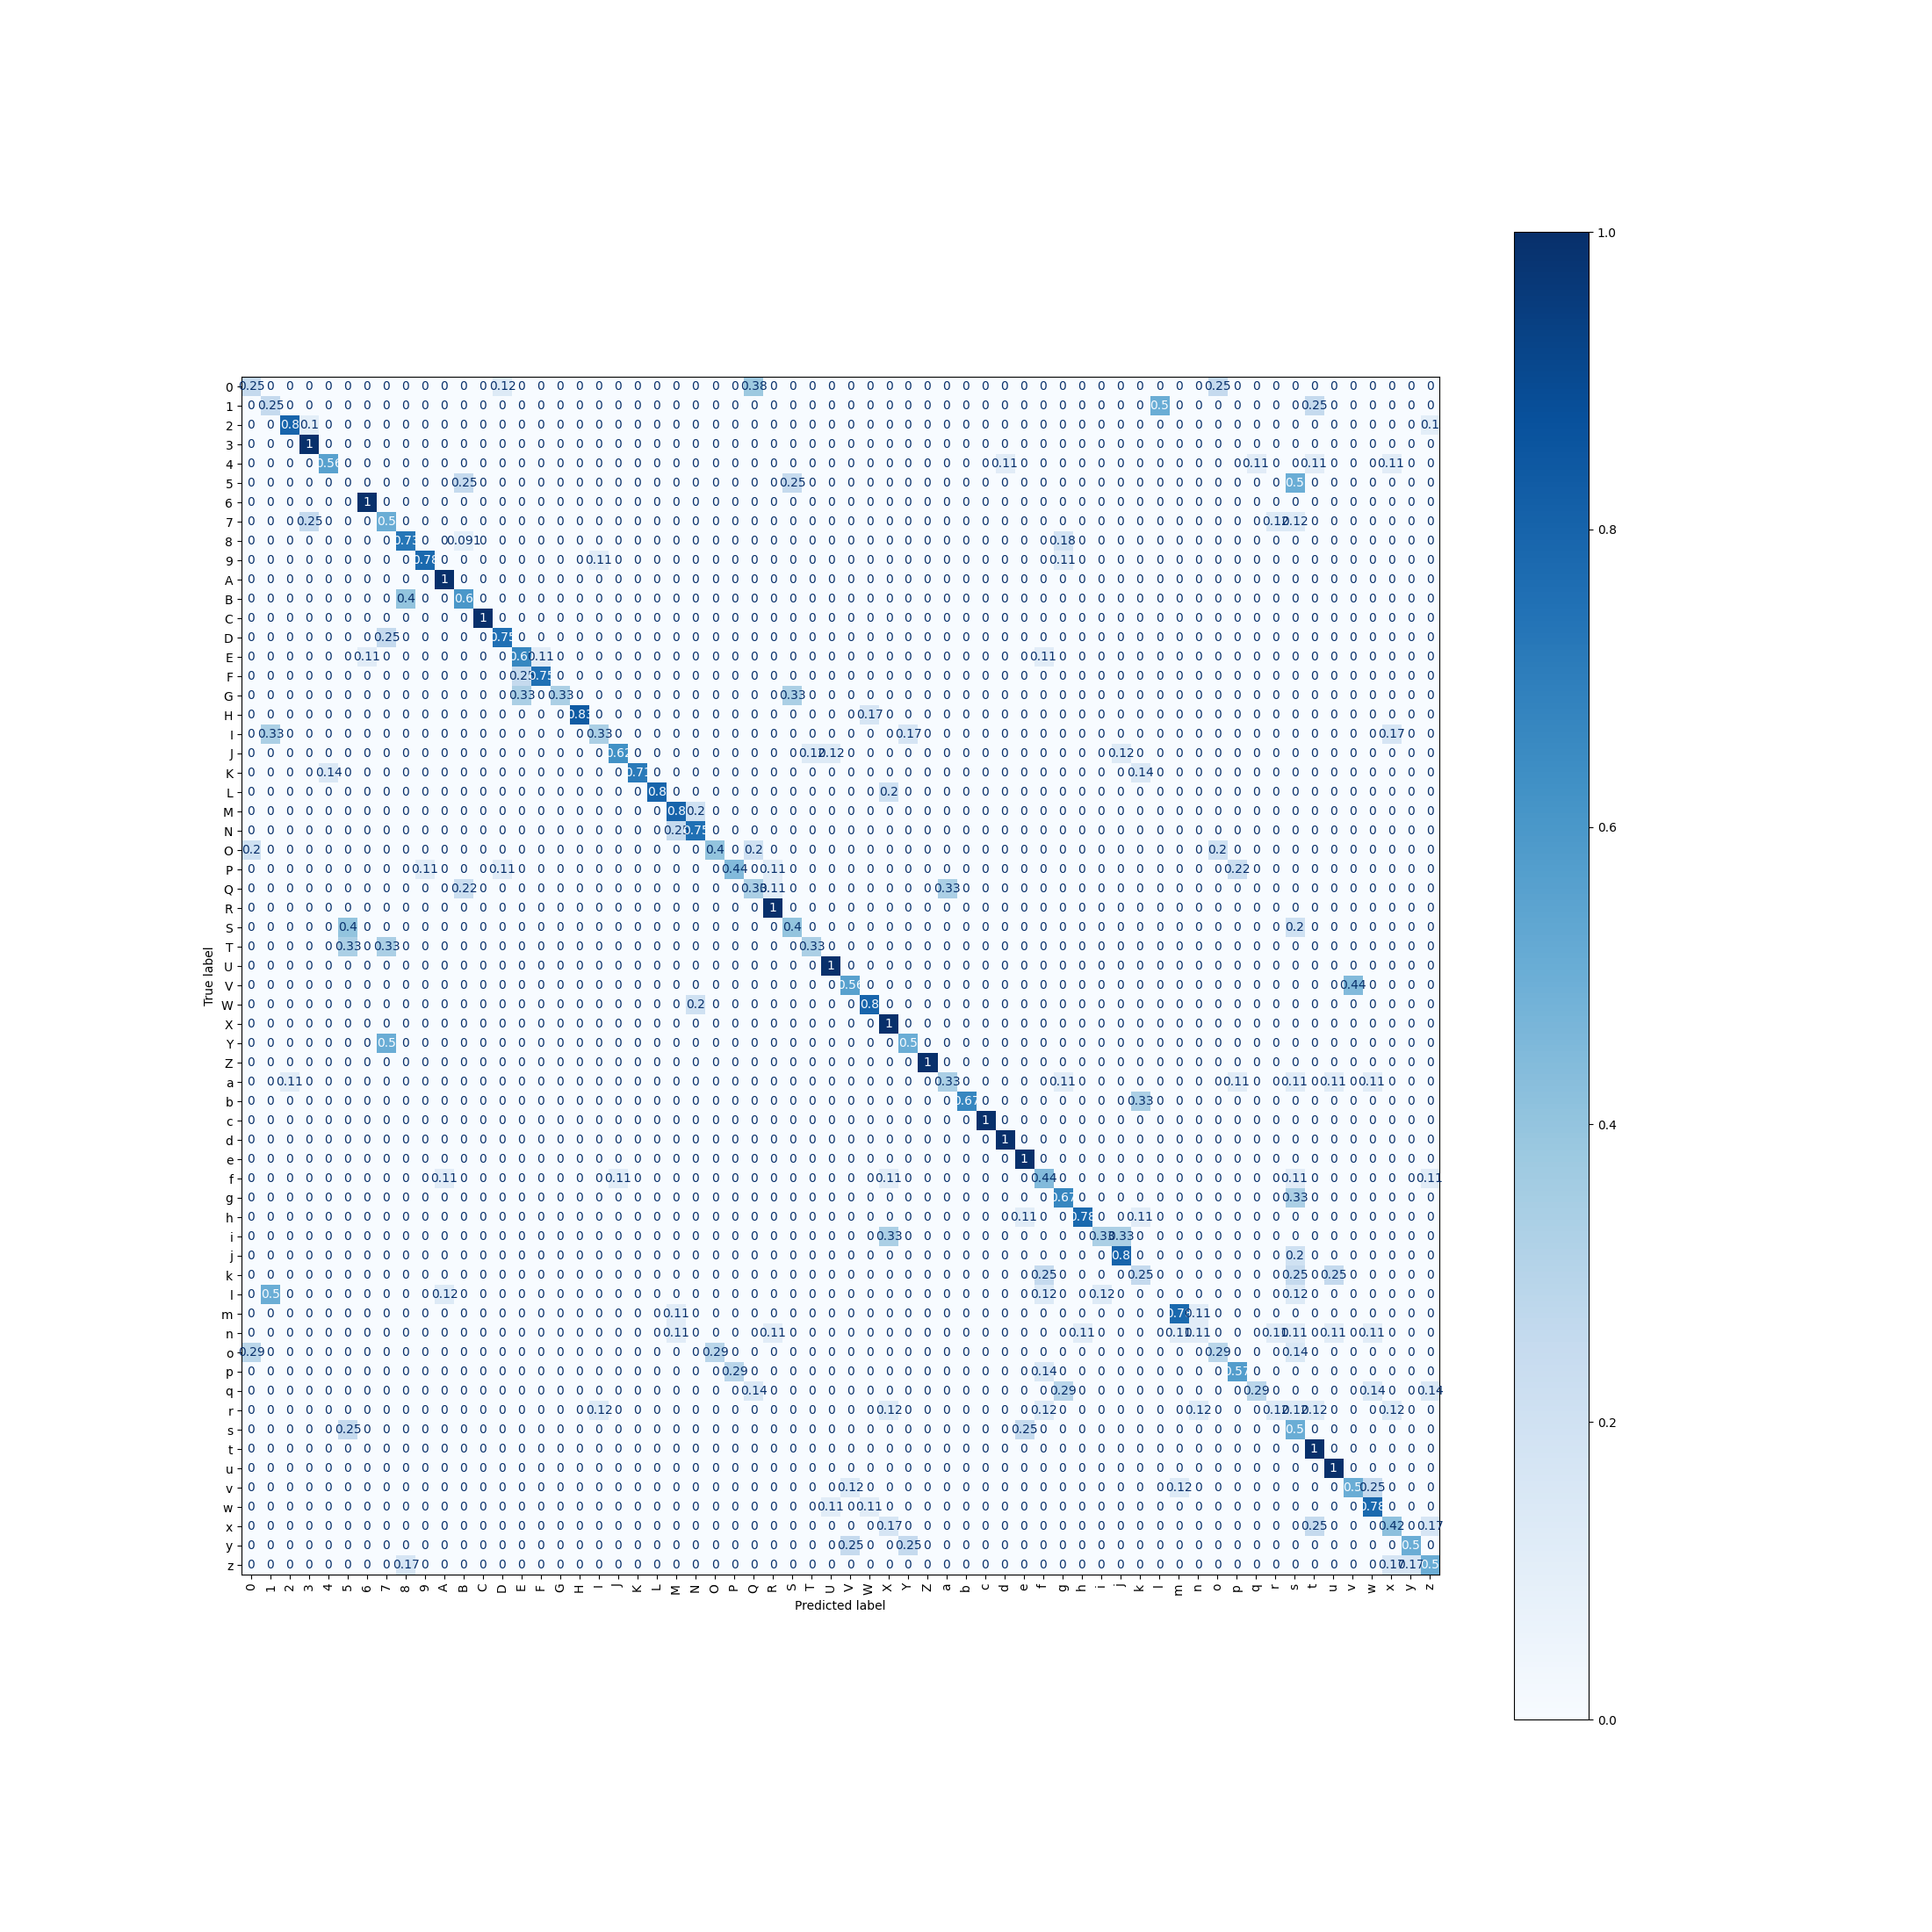

From the confusion matrix, a few inferences can be made:

-   Performance across the classes isn't consistent, with many classes
    having 100% accuracy whereas for others it drops to even 0%. While
    60% is the average, it is clearly a wide distribution of accuracy
    across the classes.
-   Intuitively, the above conclusion makes sense, as some classes can
    be easily distinguished, whereas others can be confusing even to
    human eyes.
-   This conclusion is borne out by the results. For distinctive classes
    like 'A', the accuracy is 100%, whereas for classes like 'o', its
    just 30%.

Since our dataset has 3 categories, \[0-9, a-z, A-Z\], it follows that
the worst performance will be for classes who have analogues in other
categories.

1.  "Unique" classes - Classes like "A" do not have any other similar
    classes among a-z or 0-9 and have good performance.
2.  1 analogue classes - Classes which have one analogue in another
    category. This is mostly for cases where the capital letter is
    similar to the smaller letter, such as 'p' and 'P'.
3.  2 analogue classes - Classes which have a similar shape in all
    categories. These would include \['2','z','Z'\] and \['5','s','S'\].
    These can be confusing even to human eyes if not written properly
    and here the lack of data is most apparent.

After observing this disparity between classes, I thought of an approach
to manually weight the classes so that trickier classes are penalized
heavily. However, the network was not able to make any progress using
these tweaked class weights.

The code at this stage is reproduced below to run and be tested.

[1] [EMNIST](https://www.nist.gov/itl/products-and-services/emnist-dataset)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: sriramsk1999 (use `wandb login --relogin` to force relogin)



  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv2d    | 160   
1 | conv2    | Conv2d    | 4.6 K 
2 | conv3    | Conv2d    | 18.5 K
3 | conv4    | Conv2d    | 73.9 K
4 | conv5    | Conv2d    | 295 K 
5 | fc1      | Linear    | 47.7 K
6 | pool     | MaxPool2d | 0     
7 | dropout1 | Dropout   | 0     
8 | dropout2 | Dropout   | 0     
---------------------------------------
439 K     Trainable params
0         Non-trainable params
439 K     Total params
1.760     Total estimated model params size (MB)


Epoch 0:  85%|████████▍ | 66/78 [00:01<00:00, 40.60it/s, loss=4.12, v_num=olhm, val_loss=4.120, val_acc=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  85%|████████▍ | 66/78 [00:01<00:00, 41.36it/s, loss=4.11, v_num=olhm, val_loss=4.130, val_acc=0.0188]
Validating: 0it [00:00, ?it/s]
Epoch 2:  85%|████████▍ | 66/78 [00:01<00:00, 40.42it/s, loss=3.93, v_num=olhm, val_loss=4.130, val_acc=0.0188]
Validating: 0it [00:00, ?it/s]
Epoch 3:  85%|████████▍ | 66/78 [00:01<00:00, 40.60it/s, loss=3.66, v_num=olhm, val_loss=4.100, val_acc=0.0403]
Validating: 0it [00:00, ?it/s]
Epoch 4:  85%|████████▍ | 66/78 [00:01<00:00, 40.53it/s, loss=3.37, v_num=olhm, val_loss=4.050, val_acc=0.0618]
Validating: 0it [00:00, ?it/s]
Epoch 5:  85%|████████▍ | 66/78 [00:01<00:00, 40.60it/s, loss=3.12, v_num=olhm, val_loss=3.990, val_acc=0.0806]
Validating: 0it [00:00, ?it/s]
Epoch 6:  85%|████████▍ | 66/78 [00:01<00:00, 38.42it/s, loss=2.86, v_num=olhm, val_loss=3.960, val_acc=0.129]
Validating: 0it [00:00, ?it/s]
E

Epoch 26:  85%|████████▍ | 66/78 [00:02<00:00, 30.84it/s, loss=0.998, v_num=olhm, val_loss=3.040, val_acc=0.551]
Validating: 0it [00:00, ?it/s]
Epoch 27:  85%|████████▍ | 66/78 [00:02<00:00, 30.61it/s, loss=0.811, v_num=olhm, val_loss=2.990, val_acc=0.546]
Validating: 0it [00:00, ?it/s]
Epoch 28:  85%|████████▍ | 66/78 [00:02<00:00, 30.44it/s, loss=0.829, v_num=olhm, val_loss=2.920, val_acc=0.575]
Validating: 0it [00:00, ?it/s]
Epoch 29:  85%|████████▍ | 66/78 [00:02<00:00, 30.88it/s, loss=0.799, v_num=olhm, val_loss=2.900, val_acc=0.543]
Validating: 0it [00:00, ?it/s]
Epoch 30:  85%|████████▍ | 66/78 [00:02<00:00, 30.63it/s, loss=0.719, v_num=olhm, val_loss=2.840, val_acc=0.594]
Validating: 0it [00:00, ?it/s]
Epoch 31:  85%|████████▍ | 66/78 [00:02<00:00, 30.42it/s, loss=0.747, v_num=olhm, val_loss=2.820, val_acc=0.583]
Validating: 0it [00:00, ?it/s]
Epoch 32:  85%|████████▍ | 66/78 [00:02<00:00, 31.07it/s, loss=0.709, v_num=olhm, val_loss=2.760, val_acc=0.570]
Validating: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 12/12 [00:04<00:00,  2.40it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


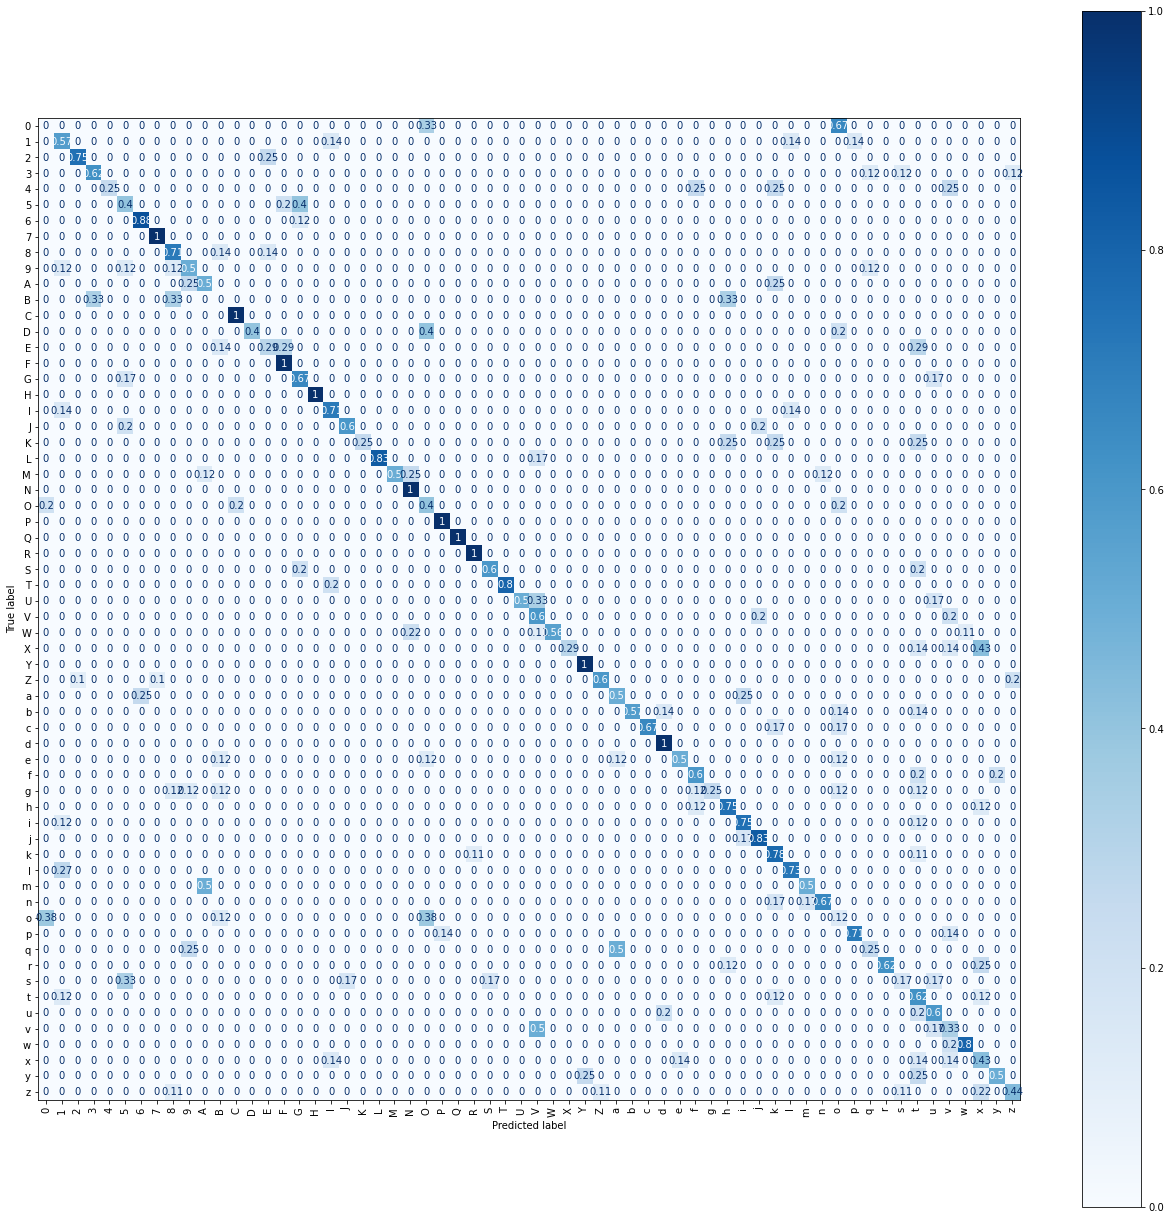

In [1]:
import os
from typing import Optional

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
from skimage import io, util
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

class NumbersAndLettersCNN(pl.LightningModule):
    ''' Implementation of CNN to detect numbers and letters. '''
    def __init__(self, input_dim, output_classes, img_labels):
        super().__init__()
        self.img_labels = img_labels
        self.cross_ent_weight = self.init_cross_entropy_weights()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)
        self.fc1 = nn.Linear(256 * 1 * 3, output_classes)
        self.pool = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.8)
        self.dropout2 = nn.Dropout(0.5)

    def init_cross_entropy_weights(self):
        w = [1 for i in self.img_labels] # init with weight = 1 for each class
        # Increase weight of tricky classes like [0,1,5,G,I,O,S,l,o,r]
        for i in [0,1,5,16,18,24,28,47,50,53]:
            w[i] += 1
        return torch.tensor(w, device='cuda', dtype=torch.float32)

    def forward(self, x):
        ''' Forward pass '''
        x = self.pool(self.dropout1(F.relu(self.conv1(x))))
        x = self.pool(self.dropout2(F.relu(self.conv2(x))))
        x = self.pool(self.dropout2(F.relu(self.conv3(x))))
        x = self.pool(self.dropout2(F.relu(self.conv4(x))))
        x = self.dropout2(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x.float())
        loss = F.cross_entropy(output, y.long(), weight=self.cross_ent_weight)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x.float())
        loss = F.cross_entropy(output, y.long())
        acc = torch.mean((torch.argmax(output, axis=1) == y).float())
        self.log_dict({'val_loss': loss, 'val_acc': acc}, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        output = self(x.float())
        acc = torch.mean((torch.argmax(output, axis=1) == y).float())
        return {'test_acc': acc,
                'test_pred': torch.argmax(output, axis=1),
                'test_actual': y}

    def test_epoch_end(self, outputs):
        test_acc = torch.squeeze(torch.stack([x['test_acc'] for x in outputs]).float()).mean()
        test_pred = torch.cat([x['test_pred'] for x in outputs]).cpu().numpy()
        test_actual = torch.cat([x['test_actual'] for x in outputs]).cpu().numpy()

        conf_mat = confusion_matrix(test_actual, test_pred, normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=self.img_labels)
        disp = disp.plot(include_values=True, cmap=plt.cm.Blues,
                         ax=None, xticks_rotation='vertical')
        disp.figure_.set_size_inches(22, 22)

        self.logger.experiment.log({"confusion_matrix":disp.figure_})
        self.logger.log_metrics({"test_acc":test_acc})

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)

class NumbersAndLettersDataset(Dataset):
    ''' Dataset for numbers and letters. '''
    def __init__(self, input_data, target, transform=None):
        self.input_data = input_data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        img = io.imread(self.input_data[idx], as_gray=True)
        img = torch.tensor(util.invert(img)) # Invert colours to be white on black
        img = torch.unsqueeze(img, 0)
        if self.transform: img = self.transform(img)
        return (img, self.target[idx])

class NumbersAndLettersModule(pl.LightningDataModule):
    ''' DataModule for loading of dataset. '''
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.img_dataset, self.img_classes, self.img_labels = self.load_data(data_dir)
        self.batch_size = batch_size
        self.nal_train = None
        self.nal_val = None

    def setup(self, stage: Optional[str] = None):
        if stage in (None, 'fit'): # Create all datasets
            # Creating transforms
            transform = transforms.Compose([
                transforms.Resize((90, 120)), # Scale down image
                transforms.Normalize((0.0583), (0.2322)),
                transforms.GaussianBlur(3),
                transforms.RandomRotation(30),
                transforms.Lambda(lambda img: img + np.random.normal(size=np.array(img.shape), scale=0.1)),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            ])

            dataset = NumbersAndLettersDataset(self.img_dataset, self.img_classes, transform)

            # Creating train, val datasets according to an 85-15 split
            self.nal_train, self.nal_val = train_test_split(dataset, test_size=0.15)

    def train_dataloader(self):
        return DataLoader(self.nal_train, batch_size=self.batch_size, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.nal_val, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.nal_val, batch_size=self.batch_size, num_workers=4)

    def load_data(self, img_dir):
        ''' Load image_paths and their classes from disk. '''
        dataset = []
        classes = []
        for folder in os.listdir(img_dir):
            img_class = int(folder[-2:]) # Extract last 2 digits of folder name
            if img_class < 11:
                img_class = str(img_class - 1) # 0-9
            elif img_class < 37:
                img_class = chr(img_class + 54) # A-Z
            else: img_class = chr(img_class + 60) # a-z
            for img in os.listdir(os.path.join(img_dir, folder)):
                img_path = os.path.join(img_dir, folder, img)
                dataset.append(img_path)
                classes.append(img_class)

        # Prepare using Label Encoding
        le = LabelEncoder()
        le.fit(classes)
        labels = le.classes_
        classes = torch.tensor(le.transform(classes))
        return dataset, classes, labels

BATCH_SIZE = 32
BASE_DIR = "train"
SAVE_PATH = "models/"
MODEL_NAME = '5conv1fc_drop_10x_blur&rotate&jitter&affine_cross-ent-weight'

INPUT_DIM = torch.tensor([3, 900, 1200])
OUTPUT_CLASSES = 62

# Create DataModule to handle loading of dataset
data_module = NumbersAndLettersModule(BASE_DIR, BATCH_SIZE)

# Train and test model

model = NumbersAndLettersCNN(INPUT_DIM, OUTPUT_CLASSES, data_module.img_labels)

# Log metrics to WandB
wandb_logger = pl.loggers.WandbLogger(save_dir='logs/',
                                        name=MODEL_NAME,
                                        project='midas-task-2')
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
)

trainer = pl.Trainer(gpus=1, logger=wandb_logger,
                     callbacks=[early_stopping], min_epochs=5)
trainer.fit(model, data_module)
trainer.test(model=model, datamodule=data_module)

# Save model
torch.save(model.state_dict(), os.path.join(SAVE_PATH, MODEL_NAME))


**Further Improvements**

1.  If real world data is not available, more data could be synthesized
    using measures like Generative Adversarial Networks (GAN) or
    Variational Autoencoders (VAE).
2.  Deeper netowrks, incorporating techniques from state-of-the-art
    architectures such as ResNet or Inception, would help boost the
    accuracy by virtue of their features like residual connections which
    would help in avoiding overfitting.